In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ✅ Global variable for number of buckets
num_buckets = 15  # Adjust as needed


# Load and Explore Data
We assume the dataset contains FICO scores and default labels (default = 1 for defaults, 0 otherwise).

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  
        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.000000e+04              10000.000000          10000.000

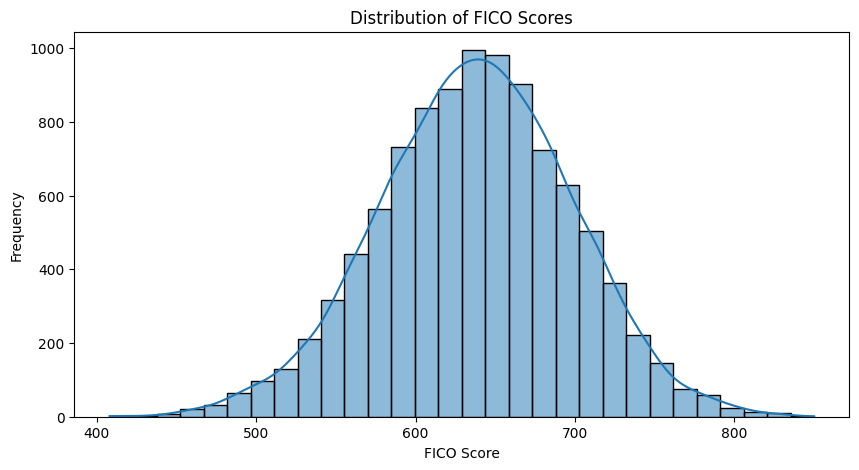

In [2]:
# ✅ Load data from GitHub
github_token = "token"  # Replace with your actual token
repo_owner = "username"
repo_name = "reponame"
file_path = "data/Task 3 and 4_Loan_Data.csv"  # Adjust path if inside a folder
# GitHub API URL
github_api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{file_path}"

# Request the file with authentication
headers = {"Authorization": f"token {github_token}"}
response = requests.get(github_api_url, headers=headers)

if response.status_code == 200:
    file_info = response.json()
    file_download_url = file_info['download_url']

    # Load the CSV file
    df = pd.read_csv(file_download_url)

else:
    print(f"❌ Error: Unable to fetch file. Status Code: {response.status_code}")

# Display first few rows
print(df.head())

# Summary statistics
print(df.describe())

# ✅ Plot FICO Score Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['fico_score'], bins=30, kde=True)
plt.xlabel("FICO Score")
plt.ylabel("Frequency")
plt.title("Distribution of FICO Scores")
plt.show()


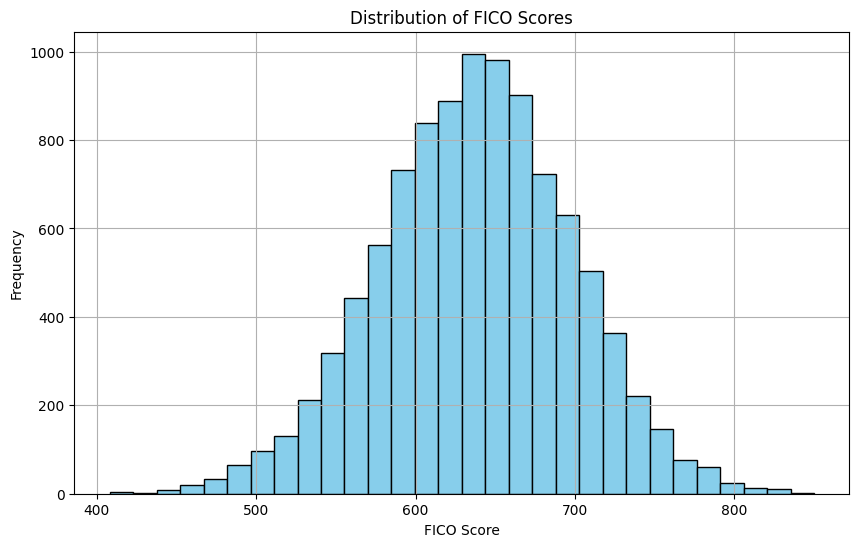

In [3]:
import matplotlib.pyplot as plt

# Plot the FICO score distribution
plt.figure(figsize=(10,6))
plt.hist(df['fico_score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Log-Likelihood: -4243.167282996169
Mean cross-validation score: 0.9858571428571429


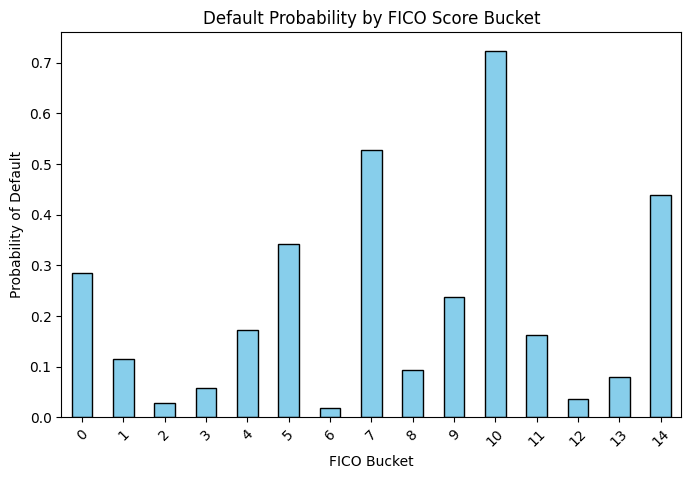

In [4]:

# ✅ Global variable for number of buckets
num_buckets = 15  # Adjust as needed

# Perform K-means clustering for FICO scores to determine optimal buckets
kmeans = KMeans(n_clusters=num_buckets, random_state=42)
df['fico_cluster'] = kmeans.fit_predict(df[['fico_score']])

# Show the bucket statistics for K-means clustering
bucket_stats_kmeans = df.groupby('fico_cluster').agg(
    total_customers=('fico_score', 'count'),
    total_defaults=('default', 'sum')
)
bucket_stats_kmeans['probability_default'] = bucket_stats_kmeans['total_defaults'] / bucket_stats_kmeans['total_customers']

# Create new feature: Debt-to-income ratio
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']

# Feature interaction between FICO score and years employed
df['fico_years_employed_interaction'] = df['fico_score'] * df['years_employed']

# Check the first few rows to see the new features
df[['fico_score', 'debt_to_income', 'fico_years_employed_interaction']].head()

# Log-Likelihood (LL) calculation using K-means bucket stats
log_likelihood = 0
for i, row in bucket_stats_kmeans.iterrows():
    ki = row['total_defaults']
    ni = row['total_customers']
    pi = row['probability_default']
    log_likelihood += (ki * np.log(pi)) + ((ni - ki) * np.log(1 - pi))

print(f"Log-Likelihood: {log_likelihood}")

# Define features and target
features = ['fico_score', 'income', 'debt_to_income', 'fico_years_employed_interaction']
X = df[features]
y = df['default']

# Scale the features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create a logistic regression model
model = LogisticRegression(random_state=42)

# Cross-validation for model performance
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Display the mean cross-validation score
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Plot the distribution of default probability by FICO score bucket
plt.figure(figsize=(8,5))
bucket_stats_kmeans['probability_default'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Default Probability by FICO Score Bucket')
plt.xlabel('FICO Bucket')
plt.ylabel('Probability of Default')
plt.xticks(rotation=45)
plt.show()
